<a href="https://colab.research.google.com/github/HSavich/dialect_discrimination/blob/master/dialect_discrimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install transformers datasets
!pip install datasets[audio]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
! pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Construct the dataset

In [18]:
from datasets import load_dataset, interleave_datasets, Audio, concatenate_datasets

In [19]:
p_r = load_dataset('openslr', 'SLR74')

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
p_r

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'sentence'],
        num_rows: 617
    })
})

In [21]:
id2label = dict()

In [22]:
def load_openslr_ds(ds_id, id_num, label_name):
  id2label[id_num] = label_name

  ds = load_dataset('openslr', ds_id)
  ds = ds['train']
  ds_labels = [id_num] * len(ds)
  ds = ds.add_column("label", ds_labels)

  return(ds)

In [23]:
dialect_set = [('SLR71', 'Chile'),
               ('SLR72', 'Colombia'),
               ('SLR73', 'Peru'),
               ('SLR74', 'Puerto Rico'),
               ('SLR75', 'Venezuela'),
               ('SLR76', 'Basque')]

In [24]:
ds_s = []
for i, tpl in enumerate(dialect_set):
  ds_s.append(load_openslr_ds(tpl[0], i, tpl[1]))
dialects = interleave_datasets(ds_s)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
dialects = dialects.remove_columns(["path","sentence"])

# Extract Features

In [26]:
from transformers import AutoFeatureExtractor

In [27]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:370: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [28]:
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [29]:
dialects = dialects.cast_column("audio", Audio(sampling_rate=16_000))

In [30]:
dialects[0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/21c1379060f244a7d781b32d9ed00cda66700ab25a095f4347868531b32d0f47/clf_09334_01278378087.wav',
  'array': array([-0.00021504, -0.00038524, -0.00025246, ...,  0.00122145,
          0.00151227,  0.00215219], dtype=float32),
  'sampling_rate': 16000},
 'label': 0}

In [31]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

In [32]:
encoded_dialects = dialects.map(preprocess_function, remove_columns="audio", batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [33]:
train_test = encoded_dialects.train_test_split(test_size = 0.1)

# Model Train

In [34]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

In [35]:
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=6)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:370: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_hid.weight', 'project_hid.bias', 'project_q.bias', 'quantizer.weight_proj.weight', 'project_q.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.weight', 'classifier.bias', 'classifier

In [36]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=10,
)

In [37]:
train_test["train"]

Dataset({
    features: ['label', 'input_values'],
    num_rows: 3331
})

In [38]:
train_test['test']

Dataset({
    features: ['label', 'input_values'],
    num_rows: 371
})

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_test["train"],
    eval_dataset=train_test["test"],
    tokenizer=feature_extractor)

In [40]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3331
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4170
  Number of trainable parameters = 94570118


Epoch,Training Loss,Validation Loss
1,No log,1.480888
2,1.563300,1.136562
3,1.004700,0.796438
4,0.691300,0.816419
5,0.586200,0.592152
6,0.423600,0.901983
7,0.423600,0.531804
8,0.349700,0.601936
9,0.277900,0.709796
10,0.223200,0.616215


***** Running Evaluation *****
  Num examples = 371
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-417
Configuration saved in ./results/checkpoint-417/config.json
Model weights saved in ./results/checkpoint-417/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-417/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 371
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-834
Configuration saved in ./results/checkpoint-834/config.json
Model weights saved in ./results/checkpoint-834/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-834/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 371
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1251
Configuration saved in ./results/checkpoint-1251/config.json
Model weights saved in ./results/checkpoint-1251/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-1251/preprocessor_config.json
***** Running Evaluation

TrainOutput(global_step=4170, training_loss=0.6208663405274316, metrics={'train_runtime': 1173.172, 'train_samples_per_second': 28.393, 'train_steps_per_second': 3.554, 'total_flos': 3.0241254053568e+17, 'train_loss': 0.6208663405274316, 'epoch': 10.0})

# Evaluate Model

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [47]:
pred = trainer.predict(train_test['test'])

yhat = np.argmax(pred.predictions, axis = 1)

y_true = pred.label_ids

***** Running Prediction *****
  Num examples = 371
  Batch size = 8


In [50]:
cf = confusion_matrix(y_true, yhat)
display_labels = ['Chile','Colombia','Peru','Puerto Rico', 'Venezuala','Basque']
cf_plt = ConfusionMatrixDisplay(cf, display_labels = display_labels)

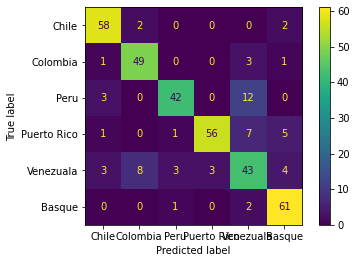

In [51]:
cf_plt.plot()

In [45]:
y_true

array([2, 0, 4, 2, 5, 4, 3, 5, 3, 4, 3, 0, 5, 1, 2, 1, 3, 0, 4, 3, 3, 4,
       2, 3, 4, 5, 5, 4, 0, 0, 3, 5, 4, 4, 3, 3, 3, 5, 5, 4, 5, 0, 1, 1,
       3, 0, 4, 4, 2, 2, 0, 4, 0, 2, 5, 5, 3, 1, 5, 5, 1, 3, 1, 2, 3, 1,
       0, 4, 0, 5, 1, 5, 3, 5, 5, 0, 2, 0, 5, 5, 0, 5, 3, 0, 1, 5, 3, 0,
       5, 0, 4, 0, 5, 0, 4, 1, 5, 3, 4, 0, 4, 3, 2, 2, 3, 1, 3, 2, 4, 3,
       5, 3, 2, 3, 2, 4, 3, 4, 3, 5, 1, 1, 2, 0, 1, 4, 1, 3, 3, 5, 4, 2,
       5, 5, 1, 4, 3, 4, 1, 0, 0, 2, 1, 1, 1, 0, 2, 2, 4, 0, 5, 1, 4, 5,
       2, 4, 5, 1, 2, 3, 4, 4, 2, 5, 4, 2, 5, 3, 1, 4, 2, 3, 5, 2, 0, 5,
       3, 2, 2, 4, 3, 5, 3, 0, 0, 3, 0, 1, 0, 4, 2, 4, 3, 2, 4, 1, 3, 2,
       0, 0, 0, 4, 4, 5, 2, 1, 0, 4, 5, 4, 3, 0, 1, 2, 2, 1, 1, 2, 2, 4,
       0, 5, 1, 4, 0, 3, 3, 2, 4, 4, 3, 4, 1, 0, 1, 5, 0, 5, 2, 5, 5, 4,
       0, 1, 5, 1, 0, 0, 2, 0, 4, 4, 2, 3, 0, 3, 5, 2, 0, 1, 5, 3, 0, 3,
       5, 0, 5, 5, 5, 0, 3, 3, 5, 5, 5, 3, 4, 3, 4, 3, 1, 0, 3, 4, 2, 0,
       4, 3, 2, 1, 4, 2, 2, 4, 0, 1, 0, 1, 4, 1, 0,

In [45]:
checkpoint = 